In [11]:
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from sklearn.isotonic import IsotonicRegression
from utils_binary_responses import *
from utils_binary_responses import main_parameters
from utils import *
from scipy.stats import beta as sp_beta
import math

from scipy.interpolate import interp1d
from scipy.integrate import quad
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
from tqdm import tqdm
import time
from scipy.integrate import simps

from scipy.interpolate import UnivariateSpline
from concurrent.futures import ThreadPoolExecutor

In [12]:
inf_X, sup_X, r_q,r_u, wage = main_parameters()

def set_parameters(K,T):
    L = T // K
    batch = [[i + j for j in range(L)] for i in range(0, T, L)]
    
    RelEff = []
    return T, K, L, batch, RelEff

In [13]:
def compute_design(smoothed, design, wage):
    x_sequence = np.linspace(0, wage, 1000)
    def sum(x):
        return smoothed(x) + design(x)*(k+1)

    area = simps(np.vectorize(sum)(x_sequence), x_sequence)
    area = max(area,10**(-14))

    def density(x):
        return sum(x)/area
    return density 

def true_sigma(x):
        return np.sqrt(F_C(x) * (1 - F_C(x)))
    
def density_oracle(x):
    def true_sigma(x):
        return np.sqrt(F_C(x) * (1 - F_C(x)))
    x_sequence = np.linspace(-0.001, wage+0.001, 1000)
    area = simps(true_sigma(x_sequence), x_sequence)
    area = max(area,10**(-14))
    
    def density(x):
        return true_sigma(x) / area
    return density(x)

def get_W_over_f(f_hat):
    true_sigma_square = lambda x: F_C(x) * (1 - F_C(x))
    f_hat_2 = lambda x: f_hat(x)#*indicator(x,-10**(-10),wage+10**(-10))
    x_sequence = np.linspace(0, wage, 1000)
    def ratio(x):
        return true_sigma_square(x)/f_hat_2(x)
    area = simps(ratio(x_sequence), x_sequence)
    area = max(area,10**(-14))
    return area

def Lambda(x):
    return f_q(x)/f_u(x) 

def indicator_Lambda(x,theta):
    if isinstance(x, (int, float)):
        return 1 if Lambda(x) > theta else 0
        
def revenue(X, theta):
    r_q = 0.7 #make sure is the same as the ones in utils_binary
    r_u = 0.4 #make sure is the same as the ones in utils_binary
    pi = F_C(Incentive(theta))
    values = [(r_q*pi*f_q(x)-r_u*(1-pi)*f_u(x))*indicator_Lambda(x,theta)/f_X(x,pi) for x in X]
    return values

def compute_revenue(t):
    J = 50
    def f_X_sample(x):
        return f_X(x, F_C(Incentive(t)))
    X = sample_from_pdf(J, f_X_sample, inf_X, sup_X)
    return sum(revenue(X, t)) / J

In [14]:
def get_batch_k(k, design, density_oracle, batch, wage, F_C, ordered_I_val, ordered_I_val_oracle, theta, theta_oracle, n, pi_hat, pi_hat_oracle):
    # Modified design
    current_batch = batch[k]
    T_k = len(current_batch)
    n_k = np.random.randint(20, 30, size=T_k)
    
    theta_k, I_val_k = get_theta(T_k, design)
    theta_k_oracle, I_val_k_oracle = get_theta(T_k, density_oracle)
    
    ordered_I_val_k = sorted(I_val_k)
    ordered_I_val_k_oracle = sorted(I_val_k_oracle)

    ordered_indexes_k = sorted(range(len(I_val_k)), key=lambda k: I_val_k[k])
    ordered_indexes_k_oracle = sorted(range(len(I_val_k_oracle)), key=lambda k: I_val_k_oracle[k])
    theta_k = [theta_k[i] for i in ordered_indexes_k]
    theta_k_oracle = [theta_k_oracle[i] for i in ordered_indexes_k_oracle]
    
    pi_k = [F_C(x) for x in ordered_I_val_k]
    pi_k_oracle = [F_C(x) for x in ordered_I_val_k_oracle]
    
    pi_hat_k = get_pi_hat(theta_k, n_k, pi_k, plot_hist=False)
    pi_hat_k_oracle = get_pi_hat(theta_k_oracle, n_k, pi_k_oracle, plot_hist=False)
    
    ordered_I_val = np.concatenate([ordered_I_val, ordered_I_val_k])
    ordered_I_val_oracle = np.concatenate([ordered_I_val_oracle, ordered_I_val_k_oracle])
    theta = np.concatenate([theta,theta_k])
    theta_oracle = np.concatenate([theta_oracle,theta_k_oracle])
    pi_hat = np.concatenate([pi_hat, pi_hat_k])
    pi_hat_oracle = np.concatenate([pi_hat_oracle, pi_hat_k_oracle])
    n = np.concatenate([n, n_k])

    index = np.argsort(ordered_I_val)
    index_oracle = np.argsort(ordered_I_val_oracle)
    
    ordered_I_val = ordered_I_val[index]
    ordered_I_val_oracle = ordered_I_val_oracle[index_oracle]
    
    pi = [F_C(x) for x in ordered_I_val] 
    pi_oracle = [F_C(x) for x in ordered_I_val_oracle] 
    
    pi_hat = pi_hat[index]
    pi_hat_oracle = pi_hat_oracle[index_oracle]
    
    sigma_hat = [np.sqrt(p * (1 - p)) for p in pi_hat]
    sigma_hat_oracle = [np.sqrt(p * (1 - p)) for p in pi_hat_oracle]
    sigma_hat_smooth = UnivariateSpline(ordered_I_val, sigma_hat)
    sigma_hat_oracle_smooth = UnivariateSpline(ordered_I_val_oracle, sigma_hat_oracle)
    
    def sigma_hat_2(x):
        return np.maximum(10**(-14), sigma_hat_smooth(x))
        
    def sigma_hat_oracle_2(x):
        return np.maximum(10**(-14), sigma_hat_oracle_smooth(x))
    
    return ordered_I_val, ordered_I_val_oracle, sigma_hat_2, sigma_hat_oracle_2, pi_hat, pi_hat_oracle, pi, n, theta

In [15]:
def update_design_density(sigma_hat, ordered_I_val, sigma_hat_oracle, ordered_I_val_oracle, design, design_oracle, RelEff, k):
    
    design = compute_design(sigma_hat, design, wage)
    design_oracle = compute_design(sigma_hat_oracle, design_oracle, wage)

    W_over_design = get_W_over_f(design)
    W_over_design_oracle = get_W_over_f(design_oracle)
    ratio = W_over_design_oracle/W_over_design    
    RelEff.append(1- ratio ** (4/5))
    #print(ratio)
    return design, design_oracle, RelEff

In [16]:
def plot_generate_axes(sigma, sigma_hat, sigma_hat_oracle, theta, rev_theta_k):
    # Plotting sigma
    x_sequence = np.linspace(0, wage, 1000).tolist()
    axes[0].plot(x_sequence, [sigma(x) for x in x_sequence] , label='$\sigma$ true', color='red', linestyle='-')
    axes[0].plot(x_sequence, [sigma_hat(x) for x in x_sequence], label='$\hat{\sigma}$', color='green', linestyle='-')
    axes[0].plot(x_sequence, [sigma_hat_oracle(x) for x in x_sequence], label='$\sigma$ oracle', color='blue', linestyle='-')
    axes[0].set_xlabel('$I(\\theta)$')
    axes[0].set_title('True/Estimated design, batch {}'.format(k))
    axes[0].legend()

    # Plotting regression
    axes[1].plot(theta, rev_theta_k, label='Expected firm revenue', color='red')
    axes[1].set_xlabel('$\\theta$')
    axes[1].set_ylabel('')
    axes[1].legend()
    axes[1].set_title('Expected firm revenue, batch {}'.format(k))
    axes[1].legend(fontsize=6)

In [17]:
F_C_names = ['Beta(3,4)','Beta(3,3)','Beta(4,3)'] #['Gaussian','Laplace', 'Logistic','Beta']

In [18]:
number_of_evaluations = 10 #50
T = 500 #number of total deployments #50
K = math.floor(T**(2/5)*2) #number of batches

In [19]:
execute_revenue = False
if execute_revenue == True:
    data_dict = {}
    for F_C_name in F_C_names:
        data_dict[F_C_name] = [np.zeros((K, number_of_evaluations)),np.zeros((K, number_of_evaluations))]
else:
    data_dict = {}
    for F_C_name in F_C_names:
        data_dict[F_C_name] = np.zeros((K, number_of_evaluations))
        
def mean_and_ci(matrix):
    mean_vals = np.mean(matrix, axis=1)
    ci_low = np.percentile(matrix, 5, axis=1)
    ci_high = np.percentile(matrix, 95, axis=1)
    return mean_vals, ci_low, ci_high

inf_X = -5
sup_X = 5
disply_plot = False

Running: F_C=Beta(3,4), evaluation number 1


Running: F_C=Beta(3,4), evaluation number 2


Running: F_C=Beta(3,4), evaluation number 3


Running: F_C=Beta(3,4), evaluation number 4


Running: F_C=Beta(3,4), evaluation number 5


Running: F_C=Beta(3,4), evaluation number 6


Running: F_C=Beta(3,4), evaluation number 7


Running: F_C=Beta(3,4), evaluation number 8


Running: F_C=Beta(3,4), evaluation number 9


Running: F_C=Beta(3,4), evaluation number 10


Running: F_C=Beta(3,3), evaluation number 1


Running: F_C=Beta(3,3), evaluation number 2


Running: F_C=Beta(3,3), evaluation number 3


Running: F_C=Beta(3,3), evaluation number 4


Running: F_C=Beta(3,3), evaluation number 5


Running: F_C=Beta(3,3), evaluation number 6


Running: F_C=Beta(3,3), evaluation number 7


Running: F_C=Beta(3,3), evaluation number 8


Running: F_C=Beta(3,3), evaluation number 9


Running: F_C=Beta(3,3), evaluation number 10


Running: F_C=Beta(4,3), evaluation number 1


Running: F_C=Beta(4,3), evaluation number 2


Running: F_C=Beta(4,3), evaluation number 3


Running: F_C=Beta(4,3), evaluation number 4


Running: F_C=Beta(4,3), evaluation number 5


Running: F_C=Beta(4,3), evaluation number 6


Running: F_C=Beta(4,3), evaluation number 7


Running: F_C=Beta(4,3), evaluation number 8


Running: F_C=Beta(4,3), evaluation number 9


Running: F_C=Beta(4,3), evaluation number 10


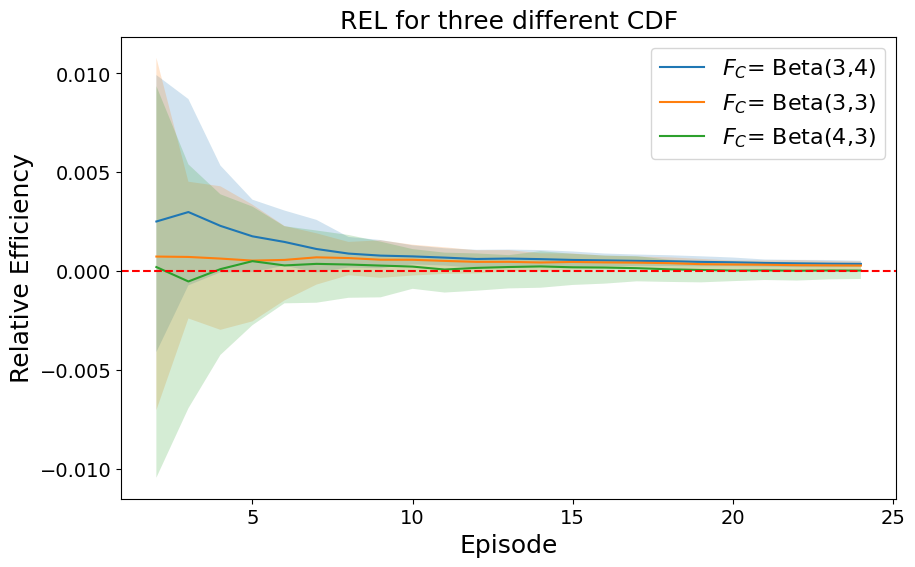

In [20]:
axis_font_size = 14
for F_C_name, matrices in data_dict.items(): #The first matrix is Rel_Eff, The second is the Revenue
    F_C = get_cdf(F_C_name)
    if execute_revenue == True:
        # Compute theta that maximize the revenue
        theta_sequence = np.linspace(inf_X, sup_X, 100)
        maxima_rev = 0
        theta_max_rev = theta_sequence[0]
        for t in theta_sequence:
            rev = compute_revenue(t)
            if rev > maxima_rev:
                maxima_rev = rev
                theta_max_rev = t

    # Start evaluations 
    for eval in range(number_of_evaluations):
        print("Running: F_C={}, evaluation number {}".format(F_C_name, eval+1))
        
        T, K, L, batch, RelEff = set_parameters(K,T)
        ordered_I_val= []
        ordered_I_val_oracle = []
        n = []
        pi_hat = []
        pi_hat_oracle = []
        theta = []
        theta_oracle = []
        
        if disply_plot == True and eval == 0:
            fig_intermediate, axes = plt.subplots(1 , 2, figsize=(10, 4))
            plt.suptitle('Optimal sequential design with $F_C$= {}'.format(F_C_name,), fontsize=16)
        
        iterable = range(K)
        for k in tqdm(iterable, desc="Processing items", unit="item", leave=False):
            design = lambda x: indicator(x,0,wage)/wage
            design_oracle = lambda x: indicator(x,0,wage)/wage
            
            #compute design
            ordered_I_val, ordered_I_val_oracle, sigma_hat, sigma_hat_oracle, pi_hat, pi_hat_oracle, pi, n, theta = get_batch_k(k, design, density_oracle, batch, wage, F_C, ordered_I_val, ordered_I_val_oracle, theta, theta_oracle, n, pi_hat, pi_hat_oracle)
            
            #compute revenue at batch k
            if execute_revenue == True:
                rev = compute_revenue(theta_max_rev)
                matrices[1][k,eval] = maxima_rev-rev
                #print('{}-th revenue is {}'.format(k,maxima_rev-rev))
                    
            design, design_oracle, RelEff = update_design_density(sigma_hat, ordered_I_val, sigma_hat_oracle, ordered_I_val_oracle, design, design_oracle, RelEff, k)

        if eval == 0:
            sigma_hat_sum = lambda x: sigma_hat(x)
            sigma_hat_oracle_sum = lambda x: sigma_hat_oracle(x)
        else:
            sigma_hat_sum_old = sigma_hat_sum
            sigma_hat_oracle_sum_old = sigma_hat_oracle_sum
            sigma_hat_sum = lambda x: sigma_hat_sum_old(x) + sigma_hat(x)
            sigma_hat_oracle_sum = lambda x: sigma_hat_oracle_sum_old(x) + sigma_hat_oracle(x)

        def sigma_hat_aver(x):
            return sigma_hat_sum(x)/number_of_evaluations
        def sigma_hat_oracle_aver(x): 
            return sigma_hat_oracle_sum(x)/number_of_evaluations
    
        if execute_revenue == True:
            matrices[0][:,eval] = RelEff
        else:
            matrices[:,eval] = RelEff
            
        if disply_plot == True:
            plot_generate_axes(true_sigma, sigma_hat_aver, sigma_hat_oracle_aver, sorted(theta), rev_theta_k)
            plt.tight_layout()  # Adjust layout spacing
            plt.savefig('plots/design:{}.png'.format(F_C_name), bbox_inches='tight', dpi=300, transparent=False)
            plt.show()
            plt.close(fig_intermediate)

if execute_revenue == True:
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    # Plot the data for each F_C on this final plot
    for F_C_name, matrices in data_dict.items():
        mean_vals_eff, ci_low_eff, ci_high_eff = mean_and_ci(matrices[0])
        mean_vals_rev, ci_low_rev, ci_high_rev = mean_and_ci(matrices[1])
        ax[0].plot(range(2, K + 1), mean_vals_eff[1:], label="$F_C$= {}".format(F_C_name))
        ax[0].fill_between(range(2, K + 1), ci_low_eff[1:], ci_high_eff[1:], alpha=0.2)
        ax[1].plot(range(2, K + 1), mean_vals_rev[1:], label="$F_C$= {}".format(F_C_name))
        ax[1].fill_between(range(2, K + 1), ci_low_rev[1:], ci_high_rev[1:], alpha=0.2)
    
    ax[0].axhline(y=0, color='red', linestyle='--')
    ax[0].set_xlabel('Batch',fontsize=14)
    ax[0].set_ylabel('Relative Efficiency',fontsize=14)
    ax[0].set_title('Relative Efficiency',fontsize=14)
    ax[0].legend()
    plt.show()

else:
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot the data for each F_C on this final plot
    for F_C_name, matrices in data_dict.items():
        mean_vals_eff, ci_low_eff, ci_high_eff = mean_and_ci(matrices)
        ax.plot(range(2, K + 1), mean_vals_eff[1:], label="$F_C$= {}".format(F_C_name))
        ax.fill_between(range(2, K + 1), ci_low_eff[1:], ci_high_eff[1:], alpha=0.2)
    
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_xlabel('Episode',fontsize=18)
    ax.set_ylabel('Relative Efficiency',fontsize=18)
    ax.set_title('REL for three different CDF',fontsize=18)
    plt.xticks(fontsize=axis_font_size)  # Set x-axis tick font size
    plt.yticks(fontsize=axis_font_size)  # Set y-axis tick font size
    ax.legend(fontsize=16)
    plt.savefig('plots/RelEff:{}.png'.format(F_C_name), bbox_inches='tight', dpi=300, transparent=False)
    plt.show()